In [1]:
import xgboost as xgb
import numpy as np
import pandas as pd
import time
import pickle
import os
from math import log
import matplotlib.pyplot as plt
from keras.optimizers import Adam

import sklearn
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV,KFold, ParameterGrid,StratifiedKFold, cross_val_score

from sklearn import metrics 
from sklearn.metrics import confusion_matrix, precision_recall_curve, average_precision_score, brier_score_loss, f1_score, log_loss,auc,roc_curve,auc

from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier

from sklearn.decomposition import PCA
#from sklearn.utils.fixes import signature

from datetime import datetime

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

Using TensorFlow backend.


In [2]:
os.chdir(r"C:\Users\aman.khatri91425\Desktop\HomeCredit\Bigdata\Corpus Classification")

In [3]:
df = pd.read_excel(os.getcwd()+r"\Data Files\New Categories\Corpus_Cereals_Grains.xlsx", encoding = 'unicode_escape')

In [4]:
df.head()

,spend_group,spend_cat_raw_l1,spend_cat_raw_l2,spend_cat_raw_l3,spend_cat_raw_l4,spend_cat_raw_l5,material_group_master_data,material_group_master_data_desc,material,material_desc,...,account_number,account_number_desc,cost_center,cost_center_desc,invoice_amount,invoice_amt_rep_curr_mth_rate,label_l2,label_l3,label_l4,label_l5
0,Raw,Cereals & Grains,C&G/ Wheat (not Durum),ZZ C&G/Whe/ Whole,ZZ C&G/Whe/ Whole,Not assigned,R10,Cereals & Grains,43896539,Wheat Soft Whole Grain Bumped 25kg Halal,...,N001/#,N001/Not assigned,0027/#,0027/Not assigned,790500.00,14837.86,C&G/ Wheat (not Durum),NaN,NaN,NaN
1,Raw,Cereals & Grains,C&G/ Wheat (not Durum),ZZ C&G/Whe/ Whole,Not assigned,Not assigned,R10,Cereals & Grains,43885489,Flour Wheat Whole 11%Protein 2.0%Ash,...,N001/#,N001/Not assigned,0051/#,0051/Not assigned,511036.67,72010.81,C&G/ Wheat (not Durum),NaN,NaN,NaN
2,Raw,Cereals & Grains,C&G/ Wheat (not Durum),ZZ C&G/Whe/ Whole,Not assigned,Not assigned,R10,Cereals & Grains,43932398,Flour Wheat Light Rstd 11%Prtn,...,N001/#,N001/Not assigned,0051/#,0051/Not assigned,-81175.66,-11505.57,C&G/ Wheat (not Durum),NaN,NaN,NaN
3,Raw,Cereals & Grains,C&G/ Wheat (not Durum),ZZ C&G/Whe/ Whole,Not assigned,Not assigned,R10,Cereals & Grains,43932398,Flour Wheat Light Rstd 11%Prtn,...,N001/#,N001/Not assigned,0051/#,0051/Not assigned,780260.64,109560.78,C&G/ Wheat (not Durum),NaN,NaN,NaN
4,Raw,Cereals & Grains,C&G/ Wheat (not Durum),ZZ C&G/Whe/ Whole,Not assigned,Not assigned,R10,Cereals & Grains,104169904,FARINA W 260 BellaNapoli_TRIAL,...,N001/#,N001/Not assigned,0046/#,0046/Not assigned,340.00,383.51,C&G/ Wheat (not Durum),NaN,NaN,NaN


In [5]:
df.label_l2.value_counts()

C&G/ Wheat (not Durum)    1063
C&G/ Corn                  393
C&G/ Rice                  339
C&G/ Oat                   210
C&G/ Barley                160
C&G/ Durum Wheat            51
C&G/ Quinoa                 42
C&G/ Rye                    26
C&G/ Millet                 26
C&G/ Sorghum                26
C&G/ Buckwheat              15
C&G/ Mixed Grains           14
C&G/ Spelt                   9
C&G/ Wild Rice               6
C&G/ Triticale               4
C&G/ Amaranth                3
Name: label_l2, dtype: int64

In [6]:
df.label_l2= np.where((df.label_l2 == 'C&G/ Amaranth') | (df.label_l2 == 'C&G/ Triticale') | (df.label_l2 == 'C&G/ Wild Rice')
         | (df.label_l2 == 'C&G/ Spelt') | (df.label_l2 == 'C&G/ Mixed Grains') | (df.label_l2 == 'C&G/ Buckwheat')
         , "OTHERS",df.label_l2)

In [7]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.fit(df["label_l2"])
df["label_l2_enc"]=le.transform(df["label_l2"])


# df["label_l2_enc"]=pd.get_dummies(df['label_l2']).values

In [8]:
x_column = ["material_descr_from_po","vendor_desc","account_number_desc","cost_center_desc"]
y_column = ["label_l2_enc"]
seed = 10

In [9]:
X_train_1, X_test, y_train_1, y_test = train_test_split(df[x_column], df[y_column], test_size=0.2, random_state=seed)
X_train, X_valid, y_train, y_valid = train_test_split(X_train_1, y_train_1, test_size=0.2, random_state=seed)

In [10]:
X_train.reset_index(inplace = True)
X_test.reset_index(inplace = True)
X_valid.reset_index(inplace = True)


In [11]:
print("Train sample : %.0f "% (X_train.shape[0]))
print("Valid sample : %.0f "% (X_valid.shape[0]))
print("Test sample : %.0f "% (X_test.shape[0]))

Train sample : 1527 
Valid sample : 382 
Test sample : 478 


In [12]:
print(y_train.label_l2_enc.value_counts())
print(y_valid.label_l2_enc.value_counts())
print(y_test.label_l2_enc.value_counts())

9     668
1     250
6     214
4     139
0     108
10     36
2      33
5      28
7      19
8      17
3      15
Name: label_l2_enc, dtype: int64
9     163
6      62
1      60
4      41
0      25
5       7
2       7
10      5
8       5
3       5
7       2
Name: label_l2_enc, dtype: int64
9     232
1      83
6      63
4      30
0      27
2      11
10     10
5       7
3       6
7       5
8       4
Name: label_l2_enc, dtype: int64


In [13]:
from sklearn.feature_extraction.text import CountVectorizer

for selected_col in x_column:
    sentences_train = X_train[selected_col].values
    sentences_valid = X_valid[selected_col].values
    sentences_test = X_test[selected_col].values

    vectorizer = CountVectorizer()
    vectorizer.fit(sentences_train)

    X_train = X_train.merge(pd.DataFrame(vectorizer.transform(sentences_train).toarray()),left_index=True, right_index = True)
    X_valid = X_valid.merge(pd.DataFrame(vectorizer.transform(sentences_valid).toarray()),left_index=True, right_index = True)
    X_test  = X_test.merge(pd.DataFrame(vectorizer.transform(sentences_test).toarray()),left_index=True, right_index = True)

In [14]:
all_col = list(X_train.columns)

In [15]:
all_col.remove('index')
all_col.remove('material_descr_from_po')
all_col.remove('vendor_desc')
all_col.remove('account_number_desc')
all_col.remove('cost_center_desc')

In [16]:
from keras.utils import to_categorical

# LSTM Model 

In [17]:
from keras.models import Sequential
from keras import layers

input_dim = X_train[all_col].shape[1]  # Number of features

model = Sequential()
model.add(layers.Dense(20, input_dim=input_dim, activation='relu'))
model.add(layers.Dense(11, activation='sigmoid'))

In [35]:
model.compile(loss='categorical_crossentropy', 
               optimizer='adam', 
               metrics=['accuracy'])
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 20)                42700     
_________________________________________________________________
dense_6 (Dense)              (None, 11)                231       
Total params: 42,931
Trainable params: 42,931
Non-trainable params: 0
_________________________________________________________________


In [36]:
history = model.fit(X_train[all_col], to_categorical(y_train),
                     epochs=100,
                     verbose=False,
                     validation_data=(X_valid[all_col], to_categorical(y_valid)),
                     batch_size=50)

In [37]:
loss, accuracy = model.evaluate(X_train[all_col], to_categorical(y_train), verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_valid[all_col], to_categorical(y_valid), verbose=False)
print("Valid Accuracy:  {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test[all_col], to_categorical(y_test), verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Training Accuracy: 1.0000
Valid Accuracy:  0.9581
Testing Accuracy:  0.9477


In [38]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

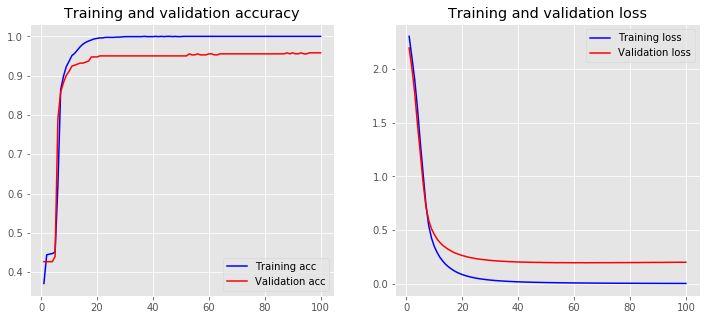

In [39]:
plot_history(history)

# Hyperparameter Tuning

In [41]:
def create_model(learning_rate=0.01, activation='relu'):
  
    # Create an Adam optimizer with the given learning rate
    opt = Adam(lr=learning_rate)
  
    # Create your binary classification model  
    model = Sequential()
    model.add(layers.Dense(29, input_dim=input_dim, activation=activation))
    model.add(layers.Dense(11, activation='sigmoid'))
    # Compile the model
    model.compile(optimizer = opt,
                  loss = 'categorical_crossentropy',
                  metrics=["accuracy"])
    return model

In [43]:
params = {'activation': ["relu", "tanh"],
          'batch_size': [16, 32, 64], 
          'epochs': [10,20,30,50],
          'learning_rate': [0.01, 0.001, 0.0001]}

In [44]:
from keras.wrappers.scikit_learn import KerasRegressor
model = KerasRegressor(build_fn = create_model,
                       verbose = 1)

In [45]:
random_search = RandomizedSearchCV(model,
                                   param_distributions = params, random_state = 10, n_iter = 20,
                                   cv = KFold(3), error_score=0, return_train_score =True)



In [46]:
print("Randomized search..")
search_time_start = time.time()
random_search.fit(X_train[all_col], to_categorical(y_train))
print("Randomized search time:", time.time() - search_time_start)

Randomized search..
Epoch 1/50
1018/1018 [==============================] - 1s 680us/step - loss: 1.8649 - accuracy: 0.4509
Epoch 2/50
1018/1018 [==============================] - 0s 180us/step - loss: 1.1201 - accuracy: 0.4617
Epoch 3/50
1018/1018 [==============================] - 0s 261us/step - loss: 0.7084 - accuracy: 0.6817
Epoch 4/50
1018/1018 [==============================] - 0s 320us/step - loss: 0.3509 - accuracy: 0.9646
Epoch 5/50
1018/1018 [==============================] - 0s 319us/step - loss: 0.1359 - accuracy: 0.9853
Epoch 6/50
1018/1018 [==============================] - 0s 399us/step - loss: 0.0672 - accuracy: 0.9961
Epoch 7/50
1018/1018 [==============================] - 0s 247us/step - loss: 0.0425 - accuracy: 0.9980
Epoch 8/50
1018/1018 [==============================] - 0s 373us/step - loss: 0.0300 - accuracy: 0.9980
Epoch 9/50
1018/1018 [==============================] - 0s 376us/step - loss: 0.0234 - accuracy: 0.9980
Epoch 10/50
1018/1018 [=====================

1018/1018 [==============================] - 1s 1ms/step - loss: 0.4356 - accuracy: 0.8242
Epoch 3/20
1018/1018 [==============================] - 1s 1ms/step - loss: 0.0714 - accuracy: 0.9853
Epoch 4/20
1018/1018 [==============================] - 2s 2ms/step - loss: 0.0293 - accuracy: 0.9921
Epoch 5/20
1018/1018 [==============================] - 2s 2ms/step - loss: 0.0169 - accuracy: 0.9951
Epoch 6/20
1018/1018 [==============================] - 1s 1ms/step - loss: 0.0141 - accuracy: 0.9951
Epoch 7/20
1018/1018 [==============================] - 1s 1ms/step - loss: 0.0052 - accuracy: 0.9990
Epoch 8/20
1018/1018 [==============================] - 2s 2ms/step - loss: 0.0069 - accuracy: 0.9971
Epoch 9/20
1018/1018 [==============================] - 2s 2ms/step - loss: 0.0040 - accuracy: 0.9990
Epoch 10/20
1018/1018 [==============================] - 2s 2ms/step - loss: 0.0039 - accuracy: 0.9990
Epoch 11/20
1018/1018 [==============================] - 2s 2ms/step - loss: 0.0036 - accura

1018/1018 [==============================] - 0s 182us/step - loss: 0.0022 - accuracy: 0.9990
Epoch 20/20
1018/1018 [==============================] - 0s 118us/step
Epoch 1/10
1018/1018 [==============================] - 0s 406us/step - loss: 2.3740 - accuracy: 0.2613
Epoch 2/10
1018/1018 [==============================] - 0s 173us/step - loss: 2.3214 - accuracy: 0.4607
Epoch 3/10
1018/1018 [==============================] - 0s 154us/step - loss: 2.2663 - accuracy: 0.4764
Epoch 4/10
1018/1018 [==============================] - 0s 163us/step - loss: 2.2101 - accuracy: 0.4686
Epoch 5/10
1018/1018 [==============================] - 0s 180us/step - loss: 2.1541 - accuracy: 0.4597
Epoch 6/10
1018/1018 [==============================] - 0s 162us/step - loss: 2.0961 - accuracy: 0.4597
Epoch 7/10
1018/1018 [==============================] - 0s 166us/step - loss: 2.0335 - accuracy: 0.4568
Epoch 8/10
1018/1018 [==============================] - 0s 163us/step - loss: 1.9645 - accuracy: 0.4568
Epoc

Epoch 12/30
1018/1018 [==============================] - 0s 177us/step - loss: 6.8401e-04 - accuracy: 1.0000
Epoch 13/30
1018/1018 [==============================] - 0s 159us/step - loss: 5.8327e-04 - accuracy: 1.0000
Epoch 14/30
1018/1018 [==============================] - 0s 182us/step - loss: 5.1726e-04 - accuracy: 1.0000
Epoch 15/30
1018/1018 [==============================] - 0s 178us/step - loss: 4.5921e-04 - accuracy: 1.0000
Epoch 16/30
1018/1018 [==============================] - 0s 262us/step - loss: 4.1074e-04 - accuracy: 1.0000
Epoch 17/30
1018/1018 [==============================] - 0s 245us/step - loss: 3.6839e-04 - accuracy: 1.0000
Epoch 18/30
1018/1018 [==============================] - 0s 190us/step - loss: 3.3627e-04 - accuracy: 1.0000
Epoch 19/30
1018/1018 [==============================] - 0s 188us/step - loss: 3.0915e-04 - accuracy: 1.0000
Epoch 20/30
1018/1018 [==============================] - 0s 182us/step - loss: 2.7952e-04 - accuracy: 1.0000
Epoch 21/30
1018/10

1018/1018 [==============================] - 0s 154us/step - loss: 0.3776 - accuracy: 0.9332
Epoch 9/30
1018/1018 [==============================] - 0s 119us/step - loss: 0.2857 - accuracy: 0.9470
Epoch 10/30
1018/1018 [==============================] - 0s 125us/step - loss: 0.2242 - accuracy: 0.9715
Epoch 11/30
1018/1018 [==============================] - 0s 120us/step - loss: 0.1799 - accuracy: 0.9774
Epoch 12/30
1018/1018 [==============================] - 0s 115us/step - loss: 0.1490 - accuracy: 0.9882
Epoch 13/30
1018/1018 [==============================] - 0s 180us/step - loss: 0.1245 - accuracy: 0.9892
Epoch 14/30
1018/1018 [==============================] - 0s 128us/step - loss: 0.1051 - accuracy: 0.9931
Epoch 15/30
1018/1018 [==============================] - 0s 169us/step - loss: 0.0905 - accuracy: 0.9961
Epoch 16/30
1018/1018 [==============================] - 0s 144us/step - loss: 0.0782 - accuracy: 0.9971
Epoch 17/30
1018/1018 [==============================] - 0s 124us/st

Epoch 40/50
1018/1018 [==============================] - 0s 112us/step - loss: 0.0292 - accuracy: 1.0000
Epoch 41/50
1018/1018 [==============================] - 0s 110us/step - loss: 0.0278 - accuracy: 0.9990
Epoch 42/50
1018/1018 [==============================] - 0s 111us/step - loss: 0.0262 - accuracy: 1.0000
Epoch 43/50
1018/1018 [==============================] - 0s 110us/step - loss: 0.0249 - accuracy: 1.0000
Epoch 44/50
1018/1018 [==============================] - 0s 100us/step - loss: 0.0238 - accuracy: 1.0000
Epoch 45/50
1018/1018 [==============================] - 0s 113us/step - loss: 0.0225 - accuracy: 1.0000
Epoch 46/50
1018/1018 [==============================] - 0s 120us/step - loss: 0.0215 - accuracy: 1.0000
Epoch 47/50
1018/1018 [==============================] - 0s 116us/step - loss: 0.0205 - accuracy: 1.0000
Epoch 48/50
1018/1018 [==============================] - 0s 123us/step - loss: 0.0196 - accuracy: 1.0000
Epoch 49/50
1018/1018 [==============================] 

1018/1018 [==============================] - 0s 106us/step
Epoch 1/20
1018/1018 [==============================] - 0s 464us/step - loss: 2.1927 - accuracy: 0.3988
Epoch 2/20
1018/1018 [==============================] - 0s 126us/step - loss: 1.8738 - accuracy: 0.4303
Epoch 3/20
1018/1018 [==============================] - 0s 105us/step - loss: 1.6440 - accuracy: 0.4352
Epoch 4/20
1018/1018 [==============================] - 0s 120us/step - loss: 1.4408 - accuracy: 0.4352
Epoch 5/20
1018/1018 [==============================] - 0s 163us/step - loss: 1.2654 - accuracy: 0.4391
Epoch 6/20
1018/1018 [==============================] - 0s 136us/step - loss: 1.1088 - accuracy: 0.4666
Epoch 7/20
1018/1018 [==============================] - 0s 106us/step - loss: 0.9577 - accuracy: 0.6012
Epoch 8/20
1018/1018 [==============================] - 0s 144us/step - loss: 0.8074 - accuracy: 0.7957
Epoch 9/20
1018/1018 [==============================] - 0s 133us/step - loss: 0.6679 - accuracy: 0.8752
Epoch

1018/1018 [==============================] - 0s 146us/step - loss: 1.9935 - accuracy: 0.4656
Epoch 22/50
1018/1018 [==============================] - 0s 144us/step - loss: 1.9723 - accuracy: 0.4656
Epoch 23/50
1018/1018 [==============================] - 0s 93us/step - loss: 1.9513 - accuracy: 0.4666
Epoch 24/50
1018/1018 [==============================] - 0s 100us/step - loss: 1.9305 - accuracy: 0.4646
Epoch 25/50
1018/1018 [==============================] - 0s 120us/step - loss: 1.9098 - accuracy: 0.4587
Epoch 26/50
1018/1018 [==============================] - 0s 91us/step - loss: 1.8892 - accuracy: 0.4597
Epoch 27/50
1018/1018 [==============================] - 0s 91us/step - loss: 1.8686 - accuracy: 0.4587
Epoch 28/50
1018/1018 [==============================] - 0s 86us/step - loss: 1.8482 - accuracy: 0.4578
Epoch 29/50
1018/1018 [==============================] - 0s 81us/step - loss: 1.8272 - accuracy: 0.4587
Epoch 30/50
1018/1018 [==============================] - 0s 96us/step - 

1018/1018 [==============================] - 0s 106us/step - loss: 1.3055 - accuracy: 0.4460
Epoch 49/50
1018/1018 [==============================] - 0s 104us/step - loss: 1.2854 - accuracy: 0.4460
Epoch 50/50
1018/1018 [==============================] - 0s 66us/step
Epoch 1/20
1018/1018 [==============================] - 1s 504us/step - loss: 2.1758 - accuracy: 0.4391
Epoch 2/20
1018/1018 [==============================] - 0s 174us/step - loss: 1.6352 - accuracy: 0.4646
Epoch 3/20
1018/1018 [==============================] - 0s 179us/step - loss: 1.1615 - accuracy: 0.4951
Epoch 4/20
1018/1018 [==============================] - 0s 198us/step - loss: 0.7179 - accuracy: 0.8644
Epoch 5/20
1018/1018 [==============================] - 0s 190us/step - loss: 0.4398 - accuracy: 0.9126
Epoch 6/20
1018/1018 [==============================] - 0s 190us/step - loss: 0.3093 - accuracy: 0.9430
Epoch 7/20
1018/1018 [==============================] - 0s 203us/step - loss: 0.2298 - accuracy: 0.9676
Epoc

Epoch 1/10
1018/1018 [==============================] - 1s 613us/step - loss: 2.1055 - accuracy: 0.4234
Epoch 2/10
1018/1018 [==============================] - 0s 250us/step - loss: 1.6938 - accuracy: 0.4460
Epoch 3/10
1018/1018 [==============================] - 0s 252us/step - loss: 1.3749 - accuracy: 0.4479
Epoch 4/10
1018/1018 [==============================] - 0s 316us/step - loss: 1.1167 - accuracy: 0.4725
Epoch 5/10
1018/1018 [==============================] - 0s 237us/step - loss: 0.8711 - accuracy: 0.7161
Epoch 6/10
1018/1018 [==============================] - 0s 266us/step - loss: 0.6209 - accuracy: 0.8949
Epoch 7/10
1018/1018 [==============================] - 0s 279us/step - loss: 0.4400 - accuracy: 0.9430
Epoch 8/10
1018/1018 [==============================] - 0s 290us/step - loss: 0.3276 - accuracy: 0.9607
Epoch 9/10
1018/1018 [==============================] - 0s 269us/step - loss: 0.2534 - accuracy: 0.9774
Epoch 10/10
1018/1018 [==============================] - 0s 264u

1018/1018 [==============================] - 0s 264us/step - loss: 1.6426 - accuracy: 0.4528
Epoch 25/30
1018/1018 [==============================] - 0s 257us/step - loss: 1.6093 - accuracy: 0.4528
Epoch 26/30
1018/1018 [==============================] - 0s 260us/step - loss: 1.5751 - accuracy: 0.4538
Epoch 27/30
1018/1018 [==============================] - 0s 249us/step - loss: 1.5400 - accuracy: 0.4538
Epoch 28/30
1018/1018 [==============================] - 0s 270us/step - loss: 1.5036 - accuracy: 0.4568
Epoch 29/30
1018/1018 [==============================] - 0s 295us/step - loss: 1.4664 - accuracy: 0.4568
Epoch 30/30
1018/1018 [==============================] - 0s 123us/step
Epoch 1/30
1018/1018 [==============================] - 0s 468us/step - loss: 2.4048 - accuracy: 0.0236
Epoch 2/30
1018/1018 [==============================] - 0s 107us/step - loss: 2.3760 - accuracy: 0.1208
Epoch 3/30
1018/1018 [==============================] - 0s 121us/step - loss: 2.3499 - accuracy: 0.3124

1018/1018 [==============================] - 0s 122us/step - loss: 1.4357e-04 - accuracy: 1.0000
Epoch 34/50
1018/1018 [==============================] - 0s 178us/step - loss: 1.3593e-04 - accuracy: 1.0000
Epoch 35/50
1018/1018 [==============================] - 0s 138us/step - loss: 1.2814e-04 - accuracy: 1.0000
Epoch 36/50
1018/1018 [==============================] - 0s 174us/step - loss: 1.2080e-04 - accuracy: 1.0000
Epoch 37/50
1018/1018 [==============================] - 0s 159us/step - loss: 1.1359e-04 - accuracy: 1.0000
Epoch 38/50
1018/1018 [==============================] - 0s 143us/step - loss: 1.0792e-04 - accuracy: 1.0000
Epoch 39/50
1018/1018 [==============================] - 0s 166us/step - loss: 1.0222e-04 - accuracy: 1.0000
Epoch 40/50
1018/1018 [==============================] - 0s 154us/step - loss: 9.6580e-05 - accuracy: 1.0000
Epoch 41/50
1018/1018 [==============================] - 0s 132us/step - loss: 9.1949e-05 - accuracy: 1.0000
Epoch 42/50
1018/1018 [========

1018/1018 [==============================] - 0s 290us/step - loss: 2.1169 - accuracy: 0.4381
Epoch 11/20
1018/1018 [==============================] - 0s 274us/step - loss: 2.0842 - accuracy: 0.4381
Epoch 12/20
1018/1018 [==============================] - 0s 272us/step - loss: 2.0516 - accuracy: 0.4381
Epoch 13/20
1018/1018 [==============================] - 0s 286us/step - loss: 2.0187 - accuracy: 0.4381
Epoch 14/20
1018/1018 [==============================] - 0s 289us/step - loss: 1.9860 - accuracy: 0.4391
Epoch 15/20
1018/1018 [==============================] - 0s 259us/step - loss: 1.9528 - accuracy: 0.4401
Epoch 16/20
1018/1018 [==============================] - 0s 227us/step - loss: 1.9193 - accuracy: 0.4401
Epoch 17/20
1018/1018 [==============================] - 0s 214us/step - loss: 1.8856 - accuracy: 0.4401
Epoch 18/20
1018/1018 [==============================] - 0s 244us/step - loss: 1.8515 - accuracy: 0.4401
Epoch 19/20
1018/1018 [==============================] - 0s 209us/s

In [47]:
print("Best Score: ",
      random_search.best_score_,
      "and Best Params: ",
      random_search.best_params_)

Best Score:  -0.33518412192525937 and Best Params:  {'learning_rate': 0.001, 'epochs': 50, 'batch_size': 32, 'activation': 'tanh'}


Model: "sequential_68"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_135 (Dense)            (None, 20)                42700     
_________________________________________________________________
dense_136 (Dense)            (None, 11)                231       
Total params: 42,931
Trainable params: 42,931
Non-trainable params: 0
_________________________________________________________________
Training Accuracy: 1.0000
Valid Accuracy:  0.9634
Testing Accuracy:  0.9498


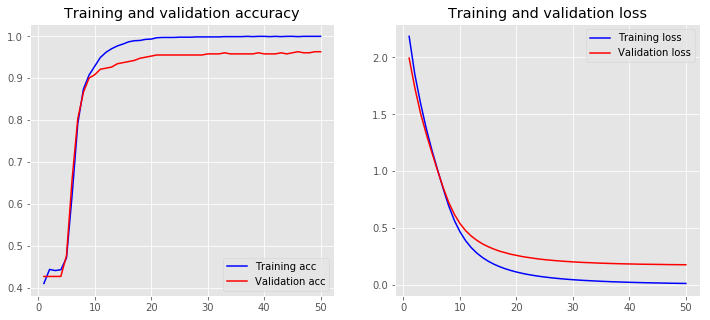

In [51]:
from keras.models import Sequential
from keras import layers

input_dim = X_train[all_col].shape[1]  # Number of features

model = Sequential()
model.add(layers.Dense(20, input_dim=input_dim, activation='tanh'))
model.add(layers.Dense(11, activation='sigmoid'))

opt = Adam(learning_rate = 0.001)

model.compile(loss='categorical_crossentropy', 
               optimizer=opt, 
               metrics=['accuracy'])
model.summary()

history = model.fit(X_train[all_col], to_categorical(y_train),
                     epochs=50,
                     verbose=False,
                     validation_data=(X_valid[all_col], to_categorical(y_valid)),
                     batch_size=32)

loss, accuracy = model.evaluate(X_train[all_col], to_categorical(y_train), verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_valid[all_col], to_categorical(y_valid), verbose=False)
print("Valid Accuracy:  {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test[all_col], to_categorical(y_test), verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

import matplotlib.pyplot as plt
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

plot_history(history)

# Model Evaluation: Test Data

In [52]:
score, acc = model.evaluate(X_test[all_col], to_categorical(y_test),
                       batch_size=16, verbose=2)

print('Test accuracy:', acc)

Test accuracy: 0.9497907757759094


Confusion matrix, without normalization


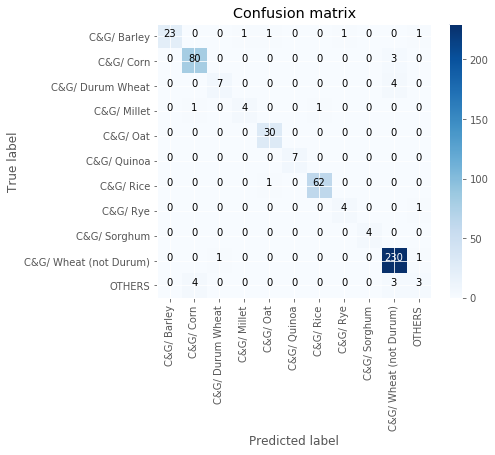

In [53]:
text_labels = le.classes_
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    # print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


y_pred = pd.DataFrame(model.predict_classes(X_test[all_col]));
cnf_matrix = confusion_matrix(y_test, y_pred)

# Plot normalized confusion matrix
fig = plt.figure()
fig.set_size_inches(7, 6, forward=True)
#fig.align_labels()

# fig.subplots_adjust(left=0.0, right=1.0, bottom=0.0, top=1.0)
plot_confusion_matrix(cnf_matrix, classes=np.asarray(text_labels), normalize=False,
                      title='Confusion matrix')

fig.savefig("txt_classification_NN_BOW" + ".png", pad_inches=5.0)


In [54]:
from sklearn.metrics import cohen_kappa_score
cohen_score = cohen_kappa_score(y_test, y_pred)
cohen_score

0.9282690660347275

In [55]:
from sklearn.metrics import precision_recall_fscore_support as score

precision, recall, fscore, support = score(y_test, y_pred)


score_dic= {'Labels':text_labels,
           'precision':precision,
            'recall':recall,
            'fscore':fscore,
            'support':support
           }

pd.DataFrame(score_dic)


,Labels,precision,recall,fscore,support
0,C&G/ Barley,1.000000,0.851852,0.920000,27
1,C&G/ Corn,0.941176,0.963855,0.952381,83
2,C&G/ Durum Wheat,0.875000,0.636364,0.736842,11
3,C&G/ Millet,0.800000,0.666667,0.727273,6
4,C&G/ Oat,0.937500,1.000000,0.967742,30
5,C&G/ Quinoa,1.000000,1.000000,1.000000,7
6,C&G/ Rice,0.984127,0.984127,0.984127,63
7,C&G/ Rye,0.800000,0.800000,0.800000,5
8,C&G/ Sorghum,1.000000,1.000000,1.000000,4
9,C&G/ Wheat (not Durum),0.958333,0.991379,0.974576,232


In [61]:
tmp = pd.DataFrame(data = cnf_matrix,index = text_labels, columns = text_labels)
tmp["total"] = tmp.sum(axis=1)
accuracy= {"Category":[],"Accuracy":[]}
for i in range(tmp.shape[0]):
    accuracy["Category"].append(tmp.index[i])
    accuracy["Accuracy"].append(tmp.iloc[i,i]/tmp.loc[tmp.index[i],"total"])

print("Accuracy:")
print(pd.DataFrame(accuracy))

Accuracy:
                  Category  Accuracy
0              C&G/ Barley  0.851852
1                C&G/ Corn  0.963855
2         C&G/ Durum Wheat  0.636364
3              C&G/ Millet  0.666667
4                 C&G/ Oat  1.000000
5              C&G/ Quinoa  1.000000
6                C&G/ Rice  0.984127
7                 C&G/ Rye  0.800000
8             C&G/ Sorghum  1.000000
9   C&G/ Wheat (not Durum)  0.991379
10                  OTHERS  0.300000


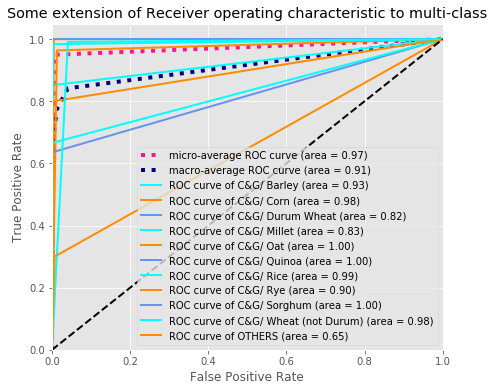

In [62]:
from sklearn.metrics import roc_curve, auc
from scipy import interp
from itertools import cycle

num_labels = 11
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(num_labels):
    fpr[i], tpr[i], _ = roc_curve((y_test==i), (y_pred == i))
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(to_categorical(y_test).ravel(), to_categorical(y_pred).ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Compute macro-average ROC curve and ROC area

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(num_labels)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(num_labels):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= num_labels

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
fig = plt.figure()
fig.set_size_inches(7, 6, forward=True)
# plt.figure()
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(num_labels), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of {0} (area = {1:0.2f})'
             ''.format(text_labels[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()

In [63]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score

# For each class
precision = dict()
recall = dict()
average_precision = dict()
for i in range(num_labels):
    precision[i], recall[i], _ = precision_recall_curve((y_test==i), (y_pred == i))
    average_precision[i] = average_precision_score((y_test==i), (y_pred == i))

# A "micro-average": quantifying score on all classes jointly
precision["micro"], recall["micro"], _ = precision_recall_curve(to_categorical(y_test).ravel(), to_categorical(y_pred).ravel())
average_precision["micro"] = average_precision_score(to_categorical(y_test), to_categorical(y_pred),
                                                     average="micro")
print('Average precision score, micro-averaged over all classes: {0:0.2f}'
      .format(average_precision["micro"]))

Average precision score, micro-averaged over all classes: 0.91


Text(0.5, 1.0, 'Average precision score, micro-averaged over all classes: AP=0.91')

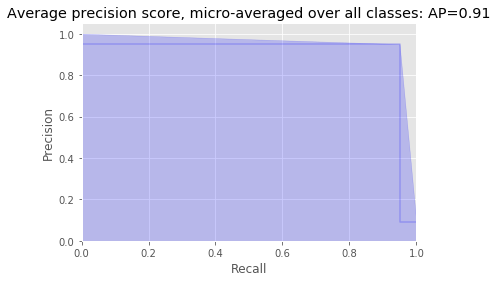

In [64]:
plt.figure()
plt.step(recall['micro'], precision['micro'], color='b', alpha=0.2,
         where='post')
plt.fill_between(recall["micro"], precision["micro"], alpha=0.2, color='b')#,
                 #**step_kwargs)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title(
    'Average precision score, micro-averaged over all classes: AP={0:0.2f}'
    .format(average_precision["micro"]))

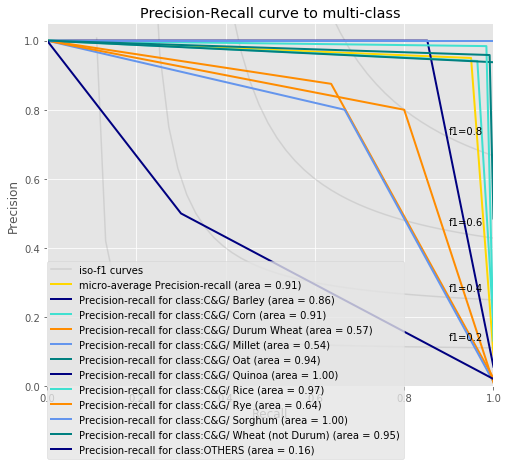

In [65]:
from itertools import cycle
# setup plot details
colors = cycle(['navy', 'turquoise', 'darkorange', 'cornflowerblue', 'teal'])

plt.figure(figsize=(8, 8))
f_scores = np.linspace(0.2, 0.8, num=4)
lines = []
labels = []
for f_score in f_scores:
    x = np.linspace(0.01, 1)
    y = f_score * x / (2 * x - f_score)
    l, = plt.plot(x[y >= 0], y[y >= 0], color='gray', alpha=0.2)
    plt.annotate('f1={0:0.1f}'.format(f_score), xy=(0.9, y[45] + 0.02))

lines.append(l)
labels.append('iso-f1 curves')
l, = plt.plot(recall["micro"], precision["micro"], color='gold', lw=2)
lines.append(l)
labels.append('micro-average Precision-recall (area = {0:0.2f})'
              ''.format(average_precision["micro"]))

for i, color in zip(range(num_labels), colors):
    l, = plt.plot(recall[i], precision[i], color=color, lw=2)
    lines.append(l)
    labels.append('Precision-recall for class:{0} (area = {1:0.2f})'
                  ''.format(text_labels[i], average_precision[i]))

fig = plt.gcf()
fig.subplots_adjust(bottom=0.25)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve to multi-class')
plt.legend(lines, labels, loc=(0, -.2), prop=dict(size=10))


plt.show()